In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def parse_file(path):
    content = {}
    with open(report_file) as file:
        line = file.readline()
        line = file.readline() # skip first line
        line = file.readline()
        while line:
            data = " ".join(line.split())
            data = data.split(" ")
            
            content[data[0]] = {
                "prec": float(data[1]),
                "rec": float(data[2]),
                "f1": float(data[3])
            }
            line = file.readline()

            if len(line) == 1:
                line = False
                
    return content

## All models in one plot

In [46]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]

contents = []
for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents.append(parse_file(report_file))

prec = []
rec = []
for content in contents:
    prec += [value["prec"] for key, value in content.items()]
    rec += [value["rec"] for key, value in content.items()]

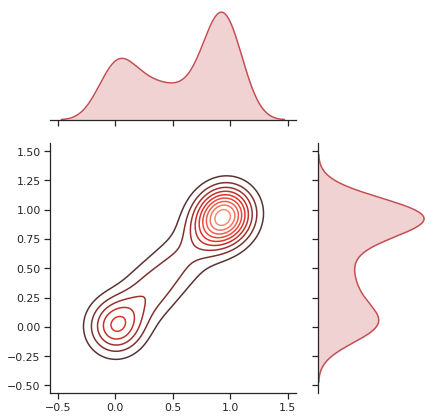

In [47]:
g = sns.JointGrid(rec, rec, height=5, ratio=2)
g = g.plot_joint(sns.kdeplot, cmap="Reds_d")
g = g.plot_marginals(sns.kdeplot, color="r", shade=True)

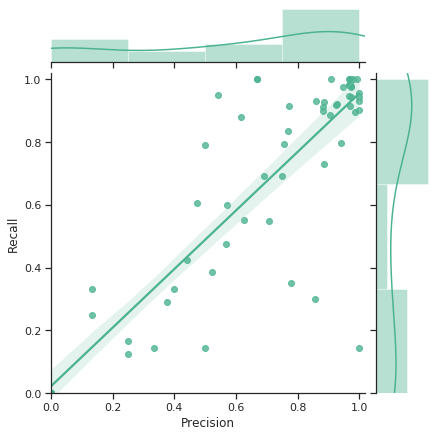

In [60]:
sns.set(style="ticks")

ax = sns.jointplot(prec, rec, height=6, kind="reg", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
# ax.plot_joint(plt.scatter, c="w", s=50, linewidth=1.5, marker="+")
ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall.pdf", format="pdf")

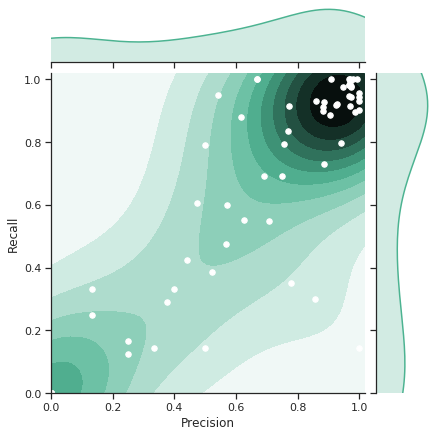

In [64]:
sns.set(style="ticks")

ax = sns.jointplot(prec, rec, height=6, kind="kde", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
ax.plot_joint(plt.scatter, c="w", s=30, linewidth=1.0, marker="o")

ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall.pdf", format="pdf")

## Seperate teacher and student

In [76]:
tfolders = ["0_teacher", "1_teacher", "2_teacher"]
tprec = []
trec = []
tf1 = []

contents = []
for f in tfolders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents = (parse_file(report_file))
    tprec += [value["prec"] for key, value in contents.items()]
    trec += [value["rec"] for key, value in contents.items()]
    tf1 += [value["f1"] for key, value in contents.items()]


sfolders = ["0_student", "1_student", "2_student"]
sprec = []
srec = []
sf1 = []

contents = []
for f in sfolders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents = (parse_file(report_file))
    sprec += [value["prec"] for key, value in contents.items()]
    srec += [value["rec"] for key, value in contents.items()]
    sf1 += [value["f1"] for key, value in contents.items()]
    
print ("teacher avg f1 = {:.4f}".format (np.sum(tf1)/len(tf1)))
print ("student avg f1 = {:.4f}".format (np.sum(sf1)/len(sf1)))

teacher avg f1 = 0.5882
student avg f1 = 0.5573


No handles with labels found to put in legend.


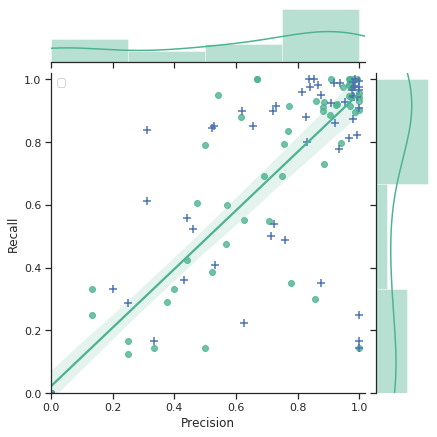

In [226]:
sns.set(style="ticks")

ax = sns.jointplot(tprec, trec, height=6, kind="reg", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
ax.x = sprec
ax.y = srec
ax.plot_joint(plt.scatter, c="b", s=50, linewidth=1.5, marker="+")
ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall.pdf", format="pdf")

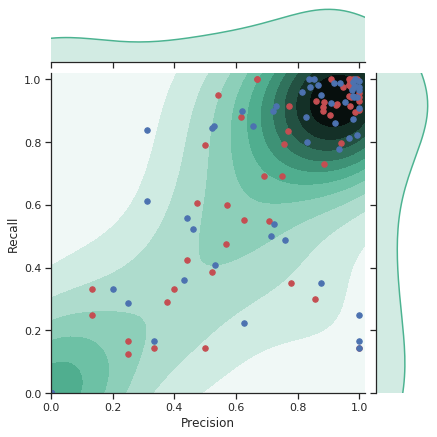

In [235]:
sns.set(style="ticks")

ax = sns.jointplot(tprec, trec, height=6, kind="kde", color="#4CB391", xlim=(0,1.02), ylim=(0,1.02) );
ax.plot_joint(plt.scatter, c="r", s=30, linewidth=1.0, marker="o")
ax.x = sprec
ax.y = srec
ax.plot_joint(plt.scatter, c="b", s=30, linewidth=1.0, marker="o")
ax = ax.set_axis_labels("Precision", "Recall")

plt.savefig("precision_recall_con.pdf", format="pdf")

## Create dataframe

In [195]:
def parse_file(path):
    
    if "teacher" in path:
        model = "teacher"
    else:
        model = "student"
        
    content = {}
    with open(report_file) as file:
        line = file.readline()
        line = file.readline() # skip first line
        line = file.readline()
        while line:
            data = " ".join(line.split())
            data = data.split(" ")
            
            content[data[0]] = {
                "prec": float(data[1]),
                "rec": float(data[2]),
                "f1": float(data[3]),
                "model": model
            }
            line = file.readline()

            if len(line) == 1:
                line = False
                
    return content

In [196]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]

first = True

for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents = parse_file(report_file)
    if first:
        df = pd.DataFrame.from_dict(contents, orient='index')
        first = False
    else: 
        new_df = pd.DataFrame.from_dict(contents, orient='index')
        df = new_df.append(df, ignore_index=True)

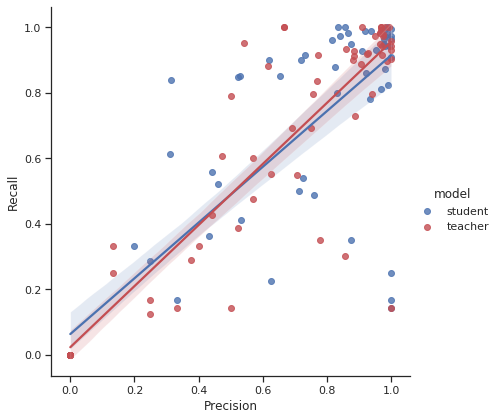

In [236]:
ax = sns.lmplot(x="prec", y="rec", hue="model", data=df, height=6, legend=True, palette=dict(student="b", teacher="r"));
ax = (ax.set_axis_labels("Precision", "Recall"))

plt.savefig("precision_recall_reg.pdf", format="pdf")

### Bar chart

In [191]:
def print_bar_chart(data, conf, title=None, fname=None, figsize=(15,6)):
    """
    Takes in list of data and makes a bar chart of it.
    Dynamically allocates placement for bars.
    """
    folders = ["Teach 0", "Stud 0", "Teach 1", "Stud 1", "Teach 2", "Stud 2"]
    
    x = np.arange(conf["num_classes"])
    width = 0.8      # 1.0 = bars side by side
    width = width/len(data)

    num_bars = len(data)
    if num_bars == 1:
        bar_placement = [0]
    # even number of bars
    elif (num_bars % 2) == 0:
        bar_placement = np.arange(-num_bars/2, num_bars/2+1)    #[-2, -1, 0, 1, 2]
        bar_placement = np.delete(bar_placement, num_bars//2)   #delete 0
        bar_placement = [bar+0.5 if bar<0 else bar-0.5 for bar in bar_placement]
    # odd number of bars
    else:
        bar_placement = np.arange(-np.floor(num_bars/2), np.floor(num_bars/2)+1)

    fig, ax = plt.subplots(figsize=figsize)

    rects = []
    for cnt, (dat, placement) in enumerate(zip(data, bar_placement)):
        rects.append(ax.bar(x+placement*width, dat, width, label=folders[cnt]))

    ax.set_ylabel('F1 score')
    if title:
        title_string = title
        ax.set_title(title_string)
    ax.set_xticks(x)
    ax.set_xticklabels(conf["class_names"])
    ax.set_axisbelow(True)
    ax.legend(loc='upper left');

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
                 rotation_mode="anchor")
    plt.grid(axis='y')


    fig.tight_layout()
    if fname:
        plt.savefig('{}/{}.pdf'.format(conf["log_dir"], fname), format='pdf')
    plt.show()

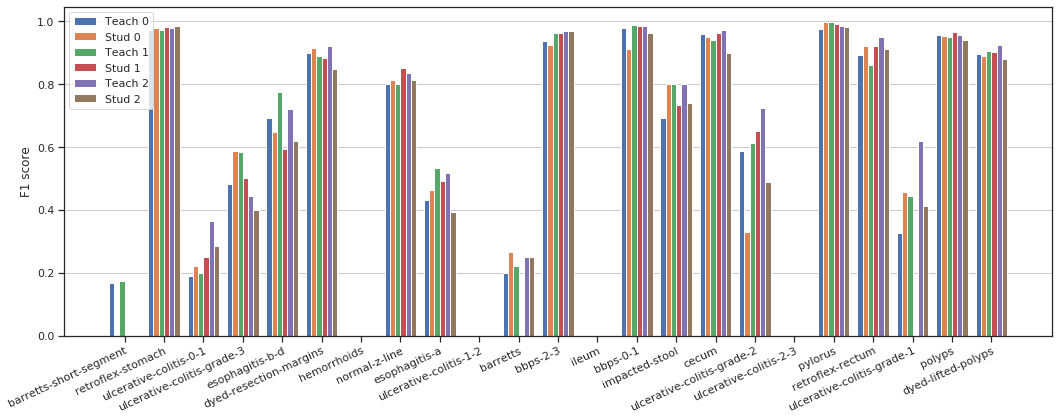

In [193]:
folders = ["0_teacher", "0_student", "1_teacher", "1_student", "2_teacher", "2_student"]

contents = []

for f in folders:
    log_dir = "/home/henriklg/master-thesis/code/hyper-kvasir/logs/experiments/model-size/teachb0-studb6/{}/".format(f)
    report_file = log_dir+"classification_report.txt"
    
    contents.append(parse_file(report_file))
    
    
f1 = []
for content in contents:
    f1.append([value["f1"] for key, value in content.items()])
    
conf = {"num_classes": 23,
        "class_names": [key for key, value in contents[0].items()],
        "log_dir": "./"}

print_bar_chart(f1, conf, fname="f1-scores")